We already have done data downloading and feature engineering in previous notebook. We are building final model in this notebook.

In [1]:
#importing all required libraries
import glob
import string
import ast
import json
import time

from datetime import date
from dateutil import parser
import datetime as dt

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
from scipy import interp
from scipy import stats
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict, defaultdict, Counter
from nltk.tokenize import TweetTokenizer

# Imports

import glob
import string
import ast

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.ensemble import ExtraTreesClassifier

#metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We are importing final processed data. we created this data after feature engineering in previous notebook and saved in CSV file

In [2]:
#importing data
all_data = pd.read_csv('Processed_final.csv', index_col='id', sep=',')
all_data.head()

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,name,...,avg_disgust,avg_fear,avg_joy,avg_negative,avg_positive,avg_sadness,avg_surprise,avg_trust,avg_negative_emoticon,avg_positive_emoticon
id,,,,,,,,,,,,,,,,,,,,,
614,1717,2201,52,4634,0,14159,0,0,0,b'Christian Harrison',...,0.129654,0.267620,0.331117,0.431848,0.788231,0.217088,0.209774,0.534907,0.000000,0.000332
1038,1426,1014,78,4272,0,33028,0,0,0,b'Martijn van Es',...,0.091451,0.163022,0.168986,0.276342,0.405567,0.129225,0.121272,0.246521,0.000000,0.005964
1437,307,204,8,359,0,3140,0,0,0,b'Ryan Kneer',...,0.176471,0.217779,0.354263,0.420026,0.638136,0.194646,0.203900,0.379379,0.000000,0.000000
2615,794,680,33,85,0,775,0,0,0,b'Sean Porter',...,0.096515,0.197051,0.286863,0.331099,0.666220,0.154155,0.154155,0.399464,0.001340,0.000000
3148,8014,3853,331,1635,0,30153,0,0,0,b'Chris Prakoso',...,0.040028,0.098123,0.232377,0.161530,0.546936,0.077931,0.122210,0.307474,0.001063,0.000000


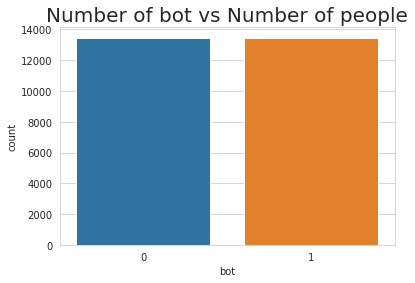

In [3]:
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=all_data)

I have creadted differenet model using various algortihm and I got best accuracy with Adaboost classifier with Random Forest as base algorithm. Hence below I will try my model first on balance dataset and further will test same model on different imbalance dataset. We are running multiple iteration of algorithm to make sure results are consistent. We are have separated out 20% dataset as testing dataset and calculating accuracy on that only.

In [4]:
from sklearn.ensemble import AdaBoostClassifier


dfList_accuracy_score_feature=[]
dfList_cross_val_score_feature=[]
dfList_f1_score_feature = []
dfList_auc_feature = []

#Now we build different model based on top 26 features(I am not getting good result on this 26 featues)
features = ['tweets_per_day','avg_In_reply','avg_retweet_count','avg_fav_count','avg_anger','avg_negative_emoticon','avg_positive_emoticon',\
            'avg_anticipation','avg_disgust','avg_fear','avg_joy','avg_negative','followers_to_friends','total_usrmention','has_extended_profile',\
            'avg_positive', 'avg_trust','avg_sadness','avg_surprise', 'avg_total_usrmention', 'nameratio','friends_count', 'followers_count','favourites_count','acc_age']
random_forest = RandomForestClassifier()

parameters = {'n_estimators': [10,20,25,50], 
              'max_features': [10,12,14,16,18,20,22], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [6, 8, 10,12], 
              'min_samples_split': [20, 30, 50],
              'min_samples_leaf': [3,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

df_train, df_test = train_test_split(all_data, test_size=0.2)
df_train = df_train.dropna(subset = ['avg_anger'])
df_test = df_test.dropna(subset = ['avg_anger'])
X_train1 = df_train[features]
Y_train1 = df_train['bot']
X_test1 = df_test[features]
Y_test1 = df_test['bot']   

#grid search
grid_obj = GridSearchCV(random_forest, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train1, Y_train1)

# Set the clf to the best combination of parameters
random_forest = grid_obj.best_estimator_

random_forest.fit(X_train1, Y_train1)


for i in range(10):
    print(50*'-')
    print(i,'th iteration')   
    ada_boost = AdaBoostClassifier(base_estimator=random_forest, n_estimators=50)
    ada_boost.fit(X_train1, Y_train1)
    predictions = ada_boost.predict(X_test1)
    calc_acc = accuracy_score(Y_test1, predictions)    
    dfList_accuracy_score_feature.append(calc_acc)
    print("accuracy_score = ", calc_acc)
    calc_cross_val_score = np.array(cross_val_score(random_forest, X_train1, Y_train1, cv=10) ).mean()
    dfList_cross_val_score_feature.append(calc_cross_val_score)
    print ("cross_val_score = ",calc_cross_val_score)
    calc_f1_score = f1_score(Y_test1,predictions)
    dfList_f1_score_feature.append(calc_f1_score)
    print ("f1_score = ",calc_f1_score)
    print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
    print (classification_report(Y_test1, predictions))
    fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
    calc_auc = auc(fpr, tpr)
    dfList_auc_feature.append(calc_auc)
    print("auc = ", calc_auc)
    print(50*'-')



--------------------------------------------------
0 th iteration
accuracy_score =  0.9197901049475262
cross_val_score =  0.9111917212486889
f1_score =  0.918723889099886
confusion_matrix =  [[2489  205]
 [ 223 2419]]
             precision    recall  f1-score   support

          0       0.92      0.92      0.92      2694
          1       0.92      0.92      0.92      2642

avg / total       0.92      0.92      0.92      5336

auc =  0.9197496103995365
--------------------------------------------------
--------------------------------------------------
1 th iteration
accuracy_score =  0.9184782608695652
cross_val_score =  0.9129290530000269
f1_score =  0.9174416397798443
confusion_matrix =  [[2484  210]
 [ 225 2417]]
             precision    recall  f1-score   support

          0       0.92      0.92      0.92      2694
          1       0.92      0.91      0.92      2642

avg / total       0.92      0.92      0.92      5336

auc =  0.918443121142281
-------------------------------

Now, We will create different imbalance dataset from test data and test it on above model that we haave built.
First imbalance dataset has 10 Bot and 100 Non bot

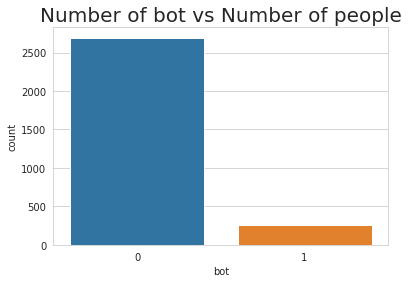

In [6]:
Bot_10 = df_test[df_test['bot']==1].sample(frac=0.1)
Non_Bot_100 = df_test[df_test['bot']==0]
dfList=[]
dfList.append(Bot_10)
dfList.append(Non_Bot_100)
Bot_10_and_Non_Bot_100=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_10_and_Non_Bot_100)

In [7]:
X_test1 = Bot_10_and_Non_Bot_100[features]
Y_test1 = Bot_10_and_Non_Bot_100['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9242731575388776
f1_score =  0.684507042253521
confusion_matrix =  [[2491  203]
 [  21  243]]
             precision    recall  f1-score   support

          0       0.99      0.92      0.96      2694
          1       0.54      0.92      0.68       264

avg / total       0.95      0.92      0.93      2958

auc =  0.9225509549841399


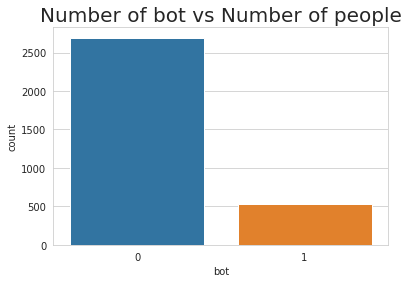

In [8]:
#Bot 20 and Non Bot 100
Bot_20 = df_test[df_test['bot']==1].sample(frac=0.2)
Non_Bot_100 = df_test[df_test['bot']==0]
dfList=[]
dfList.append(Bot_20)
dfList.append(Non_Bot_100)
Bot_20_and_Non_Bot_100=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_20_and_Non_Bot_100)

In [9]:
X_test1 = Bot_20_and_Non_Bot_100[features]
Y_test1 = Bot_20_and_Non_Bot_100['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9224084419615146
f1_score =  0.7937293729372936
confusion_matrix =  [[2491  203]
 [  47  481]]
             precision    recall  f1-score   support

          0       0.98      0.92      0.95      2694
          1       0.70      0.91      0.79       528

avg / total       0.94      0.92      0.93      3222

auc =  0.9178161064992914


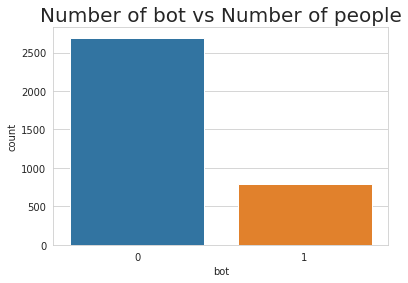

In [11]:
#Bot 30 and Non Bot 100
Bot_30 = df_test[df_test['bot']==1].sample(frac=0.3)
Non_Bot_100 = df_test[df_test['bot']==0]
dfList=[]
dfList.append(Bot_30)
dfList.append(Non_Bot_100)
Bot_30_and_Non_Bot_100=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_30_and_Non_Bot_100)

In [12]:
X_test1 = Bot_30_and_Non_Bot_100[features]
Y_test1 = Bot_30_and_Non_Bot_100['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9202753082879266
f1_score =  0.837806301050175
confusion_matrix =  [[2491  203]
 [  75  718]]
             precision    recall  f1-score   support

          0       0.97      0.92      0.95      2694
          1       0.78      0.91      0.84       793

avg / total       0.93      0.92      0.92      3487

auc =  0.9150349054598935


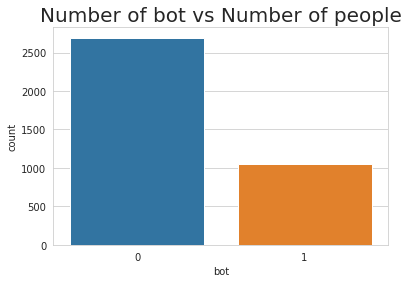

In [13]:
#Bot 40 and Non Bot 100
Bot_40 = df_test[df_test['bot']==1].sample(frac=0.4)
Non_Bot_100 = df_test[df_test['bot']==0]
dfList=[]
dfList.append(Bot_40)
dfList.append(Non_Bot_100)
Bot_40_and_Non_Bot_100=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_40_and_Non_Bot_100)

In [14]:
X_test1 = Bot_40_and_Non_Bot_100[features]
Y_test1 = Bot_40_and_Non_Bot_100['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9210877099440149
f1_score =  0.8669064748201438
confusion_matrix =  [[2491  203]
 [  93  964]]
             precision    recall  f1-score   support

          0       0.96      0.92      0.94      2694
          1       0.83      0.91      0.87      1057

avg / total       0.93      0.92      0.92      3751

auc =  0.9183312508472171


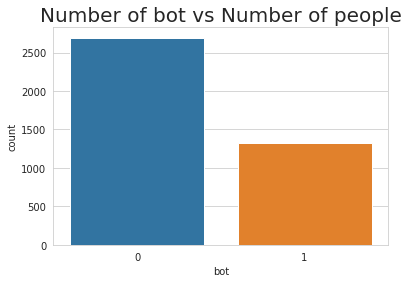

In [15]:
#Bot 50 and Non Bot 100
Bot_50 = df_test[df_test['bot']==1].sample(frac=0.5)
Non_Bot_100 = df_test[df_test['bot']==0]
dfList=[]
dfList.append(Bot_50)
dfList.append(Non_Bot_100)
Bot_50_and_Non_Bot_100=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_50_and_Non_Bot_100)

In [16]:
X_test1 = Bot_50_and_Non_Bot_100[features]
Y_test1 = Bot_50_and_Non_Bot_100['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9212951432129515
f1_score =  0.8843338213762811
confusion_matrix =  [[2491  203]
 [ 113 1208]]
             precision    recall  f1-score   support

          0       0.96      0.92      0.94      2694
          1       0.86      0.91      0.88      1321

avg / total       0.92      0.92      0.92      4015

auc =  0.9195530539449821


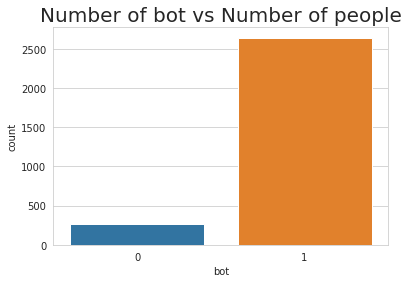

In [17]:
#Bot 100 and Non Bot 10
Bot_100 = df_test[df_test['bot']==1]
Non_Bot_10 = df_test[df_test['bot']==0].sample(frac=0.1)
dfList=[]
dfList.append(Bot_100)
dfList.append(Non_Bot_10)
Bot_100_and_Non_Bot_10=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_100_and_Non_Bot_10)

In [18]:
X_test1 = Bot_100_and_Non_Bot_10[features]
Y_test1 = Bot_100_and_Non_Bot_10['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9134318103744418
f1_score =  0.9503937007874016
confusion_matrix =  [[ 245   24]
 [ 228 2414]]
             precision    recall  f1-score   support

          0       0.52      0.91      0.66       269
          1       0.99      0.91      0.95      2642

avg / total       0.95      0.91      0.92      2911

auc =  0.9122412051251023


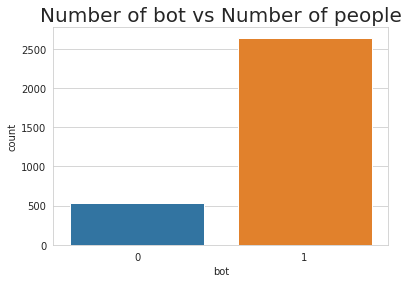

In [19]:
#Bot 100 and Non Bot 20
Bot_100 = df_test[df_test['bot']==1]
Non_Bot_20 = df_test[df_test['bot']==0].sample(frac=0.2)
dfList=[]
dfList.append(Bot_100)
dfList.append(Non_Bot_20)
Bot_100_and_Non_Bot_20=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_100_and_Non_Bot_20)

In [20]:
X_test1 = Bot_100_and_Non_Bot_20[features]
Y_test1 = Bot_100_and_Non_Bot_20['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9176359635334801
f1_score =  0.9485265225933203
confusion_matrix =  [[ 505   34]
 [ 228 2414]]
             precision    recall  f1-score   support

          0       0.69      0.94      0.79       539
          1       0.99      0.91      0.95      2642

avg / total       0.94      0.92      0.92      3181

auc =  0.9253109818698658


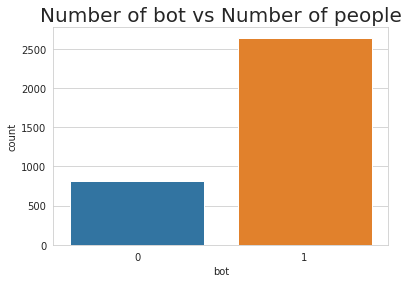

In [21]:
#Bot 100 and Non Bot 30
Bot_100 = df_test[df_test['bot']==1]
Non_Bot_30 = df_test[df_test['bot']==0].sample(frac=0.3)
dfList=[]
dfList.append(Bot_100)
dfList.append(Non_Bot_30)
Bot_100_and_Non_Bot_30=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_100_and_Non_Bot_30)

In [22]:
X_test1 = Bot_100_and_Non_Bot_30[features]
Y_test1 = Bot_100_and_Non_Bot_30['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9188405797101449
f1_score =  0.9451840250587314
confusion_matrix =  [[ 756   52]
 [ 228 2414]]
             precision    recall  f1-score   support

          0       0.77      0.94      0.84       808
          1       0.98      0.91      0.95      2642

avg / total       0.93      0.92      0.92      3450

auc =  0.9246726527308293


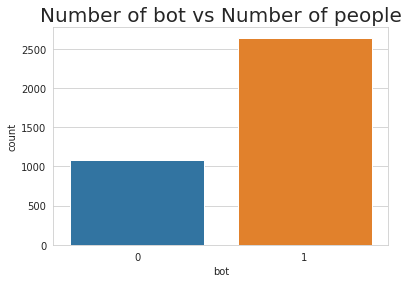

In [23]:
#Bot 100 and Non Bot 40
Bot_100 = df_test[df_test['bot']==1]
Non_Bot_40 = df_test[df_test['bot']==0].sample(frac=0.4)
dfList=[]
dfList.append(Bot_100)
dfList.append(Non_Bot_40)
Bot_100_and_Non_Bot_40=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_100_and_Non_Bot_40)

In [24]:
X_test1 = Bot_100_and_Non_Bot_40[features]
Y_test1 = Bot_100_and_Non_Bot_40['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9172043010752688
f1_score =  0.9400311526479751
confusion_matrix =  [[ 998   80]
 [ 228 2414]]
             precision    recall  f1-score   support

          0       0.81      0.93      0.87      1078
          1       0.97      0.91      0.94      2642

avg / total       0.92      0.92      0.92      3720

auc =  0.919745119161146


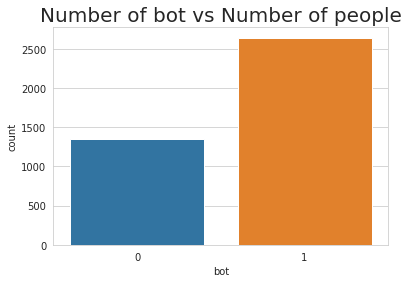

In [25]:
#Bot 100 and Non Bot 50
Bot_100 = df_test[df_test['bot']==1]
Non_Bot_50 = df_test[df_test['bot']==0].sample(frac=0.5)
dfList=[]
dfList.append(Bot_100)
dfList.append(Non_Bot_50)
Bot_100_and_Non_Bot_50=pd.concat(dfList, axis=0)
plt.title('Number of bot vs Number of people', y=1, size=20)
sns.countplot('bot', data=Bot_100_and_Non_Bot_50)

In [26]:
X_test1 = Bot_100_and_Non_Bot_50[features]
Y_test1 = Bot_100_and_Non_Bot_50['bot']
predictions = ada_boost.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print(classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.9182752569566307
f1_score =  0.9367481567714395
confusion_matrix =  [[1249   98]
 [ 228 2414]]
             precision    recall  f1-score   support

          0       0.85      0.93      0.88      1347
          1       0.96      0.91      0.94      2642

avg / total       0.92      0.92      0.92      3989

auc =  0.9204737361799316


In [27]:
#Now we build different model based on top 26 features(I am not getting good result on this 26 featues)
features = ['avg_anger',\
            'avg_anticipation','avg_disgust','avg_fear','avg_joy','avg_negative',\
            'avg_positive', 'avg_trust','avg_sadness','avg_surprise']

In [32]:
#Now we build different model based on top 26 features(I am not getting good result on this 26 featues)
features = ['tweets_per_day','avg_In_reply','avg_retweet_count','avg_fav_count','avg_anger','avg_negative_emoticon','avg_positive_emoticon',\
            'avg_anticipation','avg_disgust','avg_fear','avg_joy','avg_negative','followers_to_friends','total_usrmention','has_extended_profile',\
            'avg_positive', 'avg_trust','avg_sadness','avg_surprise', 'avg_total_usrmention', 'nameratio','friends_count', 'followers_count','favourites_count','acc_age']

In [33]:
df_train, df_test = train_test_split(all_data, test_size=0.2)
df_train = df_train.dropna(subset = ['avg_anger'])
df_test = df_test.dropna(subset = ['avg_anger'])
X_train1 = df_train[features]
Y_train1 = df_train['bot']
X_test1 = df_test[features]
Y_test1 = df_test['bot']  

In [34]:
# Decision Tree and we will chosse best one

decision_tree = DecisionTreeClassifier()

parameters = {'max_features': [10,12,14,16,18], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [3, 4], 
              'min_samples_split': [10, 20, 30],
              'min_samples_leaf': [1,5,8],
              'min_impurity_decrease': [0.00000001, 0.0000001]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(decision_tree, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train1, Y_train1)

# Set the decision_tree to the best combination of parameters
decision_tree = grid_obj.best_estimator_

decision_tree .fit(X_train1, Y_train1)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=18, max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
# To view the decision Tree
export_graphviz(decision_tree,out_file='NewNRCtree.dot',feature_names=X_train1.columns) 
predictions = decision_tree.predict(X_test1)
print("accuracy_score = ",accuracy_score(Y_test1, predictions))
print ("cross_val_score = ",np.array(cross_val_score(decision_tree, X_train1, Y_train1, cv=10) ).mean())
print ("f1_score = ",f1_score(Y_test1,predictions))
print("confusion_matrix = ",confusion_matrix(Y_test1,predictions))
print (classification_report(Y_test1, predictions))
fpr, tpr, thresholds = roc_curve(Y_test1, predictions)
print("auc = ", auc(fpr, tpr))

accuracy_score =  0.764750093949643
cross_val_score =  0.7820916172223636
f1_score =  0.7690888970859462
confusion_matrix =  [[1985  686]
 [ 566 2085]]
             precision    recall  f1-score   support

          0       0.78      0.74      0.76      2671
          1       0.75      0.79      0.77      2651

avg / total       0.77      0.76      0.76      5322

auc =  0.7648315075328129


In [37]:
emtion_data = all_data[features1]

In [38]:
emtion_data.to_csv('emtion_data.csv', index = True)

In [41]:
avg_emotion_data = emtion_data.groupby('bot', as_index=False).mean()

In [43]:
avg_emotion_data.to_csv('avg_emotion_data.csv', index = True)